In [1]:
#Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import pandas_profiling

In [2]:
#Load the data
df1 = pd.read_csv('Corona_NLP_test.csv')
df2 = pd.read_csv('Corona_NLP_train.csv')

#Because I would like to create my own testing and training subsets during the modelling stage, I've combined the 
#two datasets into one. 

df = pd.concat([df1, df2])
df = df.reset_index(drop=True)

In [3]:
#The resulting DataFrame consists of 44955 rows and 6 columns. 

df.shape

(44955, 6)

In [4]:
#Checking the first few rows of the dataset suggests that UserName and ScreenName have been replaced with integers
#ranging from 1 to 44955 and 44953 to 89907 respectively.

df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
#We can confirm this by checking the datatype of each column. 
df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [6]:
#Because the columns UserName and ScreenName do not contain any usable categorical or numerical information, I 
#decided to drop them. 

df = df[['Location', 'TweetAt', 'OriginalTweet', 'Sentiment']]

In [7]:
#Next I checked for any missing values. Calling df.isna.sum()/len(df) reveals that almost 21% of the values are 
#missing for the location column. Thankfully, the other columns appear to be complete. 

df.isna().sum()/len(df)

Location         0.209632
TweetAt          0.000000
OriginalTweet    0.000000
Sentiment        0.000000
dtype: float64

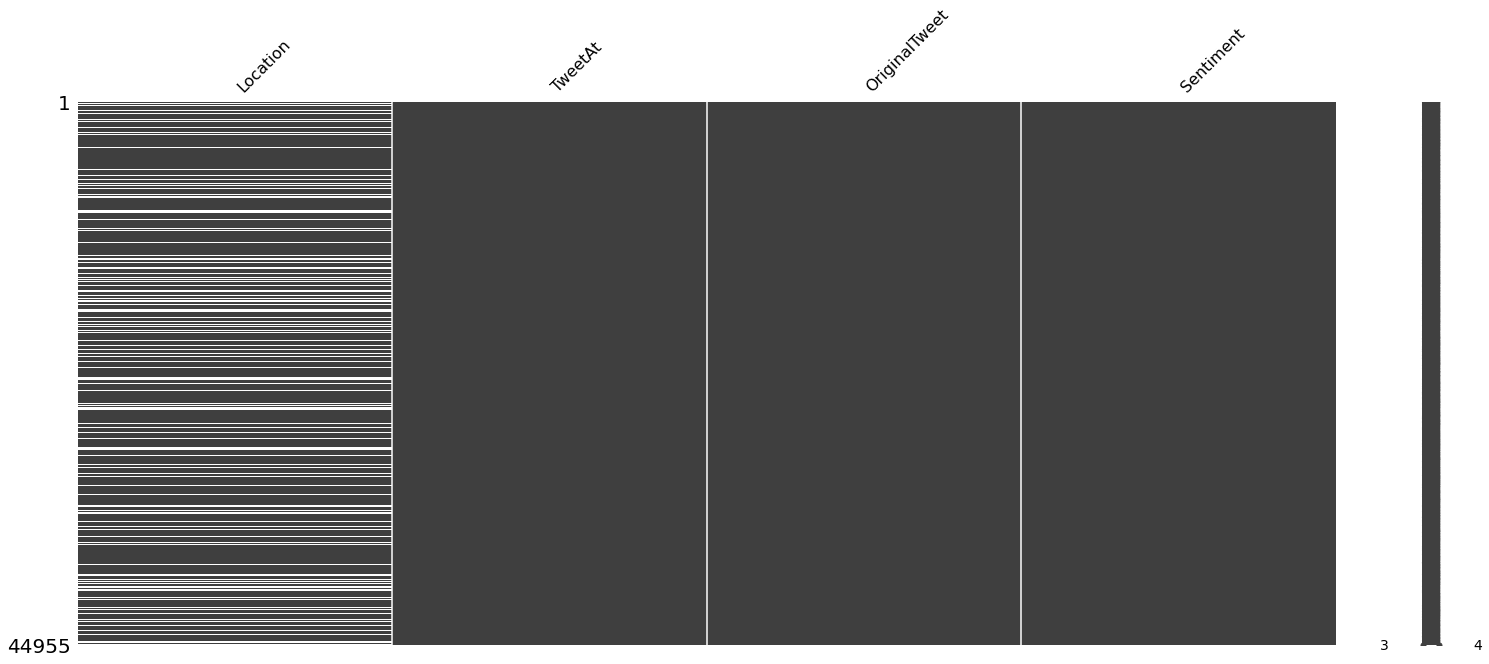

In [8]:
#I then used missingno to see if there were any patterns to the missing values for Location. When the DataFrame is 
#sorted by Index, the missing location data appears randomly distributed. 

msno.matrix(df)
plt.show()

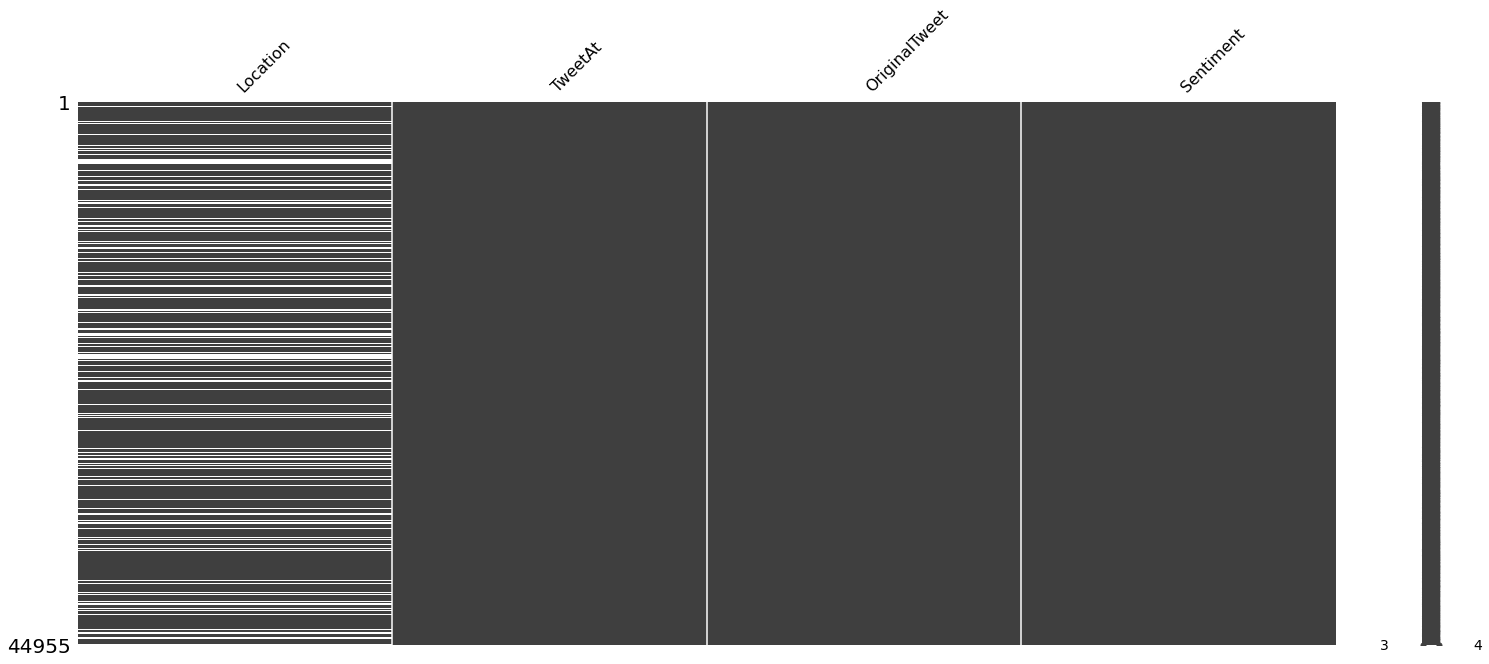

In [9]:
#Nor do any patterns emerge when sorting by TweetAt (as we might expect if, for example, a GPS satellite temporarily 
#malfunctioned). It seems that some of the location data is missing completely at random.  

msno.matrix(df.sort_values('TweetAt'))
plt.show()

In [10]:
#To confirm this, I created a Pandas profiling report to see whether there was any correlation between 
#Location and the other three columns. I set explorative to True so that I could also check the unicode data for 
#the OriginalTweet column and determine whether every Tweet was in English at a later stage of the analysis. 

report = df.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False, explorative=True)
report

In [11]:
#The Profile Report does not support a correlation between Location and any of the other columns, which means that 
#the missing values for Location are most likley missing completely at random. We can handle this result in one of 
#two ways: 1) we could drop the rows with missing values; or 2) we could drop the location column entirely. Since I 
#am more interested in the content of each Tweet than the Location of its sender for the present analysis, I opted 
#for the second option. If, however, I were conducting an analysis of public sentiment regarding COVID-19 by region, it 
#would be important to retain and standardize this data as much as possible. 

df = df[['TweetAt', 'OriginalTweet', 'Sentiment']]

In [12]:
#The Profile Report reveals something else interesting about the data: the OriginalTweet 
#column contains several Latin Supplementary characters (e.g., é, ñ), which could hint at the presence of 
#non-English Tweets. Subsetting the DataFrame on these characters yields 138 rows that could contain non-English 
#Tweets. To see all of the rows, I used pd.set_option('display.max_rows', None). Subsquently,I removed this command 
#from the code to prevent Jupyter-Notebooks from crashing when executing later cells. 

df[df['OriginalTweet'].str.contains(pat = '[éüíáñçöó]', regex=True)]

,TweetAt,OriginalTweet,Sentiment
117,11-03-2020,Hey guysss! We have a very important message t...,Extremely Positive
330,12-03-2020,"La coda allEsselunga di via Fauché, a #Milano...",Neutral
345,12-03-2020,Informoval jsem zástupce vech obchodních ?et?...,Neutral
476,12-03-2020,INCREIBLE!!!! UNBELIEVABLE!!!! The S&amp;P 500...,Extremely Negative
1362,13-03-2020,USA \r\r\n\r\r\nAmericans panic and supermarke...,Extremely Negative
...,...,...,...
43172,12-04-2020,Coronavirus T-Shirt (Golden Toilet Paper and S...,Neutral
43205,12-04-2020,Consumer Reports tested Facebook Ads' claim th...,Extremely Negative
44301,13-04-2020,Social Distancing.\r\r\nA supermarket in Parañ...,Neutral
44729,14-04-2020,Just a little consumer service announcement. \...,Positive


In [13]:
#A closer inspection of this subset indicates that only 29 of these Tweets are written entirely in a non-English 
#language. This figure does not include the Tweet stored at Index 41939  because it contains text in both Irish and 
#English. 

non_eng_indx = [330, 345, 2383, 4676, 10917, 12825, 13928, 14402, 15011, 17147, 17489, 17751, 18391, 18465, 18553, 19428, 20430, 25441, 30476, 30498, 30803, 33331, 33750, 33944, 34136, 41325, 41328, 41440, 42914]

non_eng = df.loc[non_eng_indx, :]

non_eng

,TweetAt,OriginalTweet,Sentiment
330,12-03-2020,"La coda allEsselunga di via Fauché, a #Milano...",Neutral
345,12-03-2020,Informoval jsem zástupce vech obchodních ?et?...,Neutral
2383,14-03-2020,Ahora seguid llorando por el papel higiénico (...,Negative
4676,17-03-2020,Une centaine de personnes se pressent aux port...,Neutral
10917,19-03-2020,Clientes cariocas buscando proteção contra o C...,Neutral
12825,20-03-2020,La escena se repite alrededor del mundo: desde...,Neutral
13928,20-03-2020,Geschäftsführer vieler Edeka-Märkte in der Reg...,Neutral
14402,20-03-2020,#coronavirus : les #masques arrivent\r\r\n#des...,Neutral
15011,20-03-2020,Keine Wertgegenstände im Fahrzeug lassen! - Di...,Negative
17147,21-03-2020,"Esposa: Acabou a mascara, como vai no mercado?...",Negative


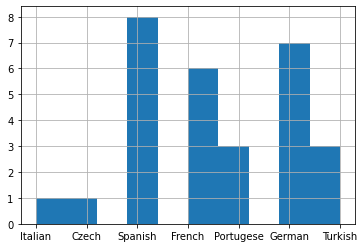

In [14]:
#Just for fun, I decided to add a column designating the language of each non-English Tweet, so that I could run 
#some summary statistics on this subset. 

non_eng_lang = ['Italian', 'Czech', 'Spanish', 'French', 'Portugese', 'Spanish', 'German', 'French', 'German', 'Portugese', 'Spanish', 'Spanish', 'German', 'German', 'Spanish', 'German', 'Turkish', 'French', 'German', 'Spanish', 'Spanish', 'French', 'Spanish', 'French', 'French', 'Turkish', 'Portugese', 'Turkish', 'German']

non_eng['Language'] = non_eng_lang

non_eng['Language'].hist()
plt.show()

In [15]:
#Although the number of non-English language tweets is probably too low to affect the outcome of my analysis, I 
#decided to remove them just to be safe. 

df = df.drop(non_eng.index)
df.reset_index(drop=True)

,TweetAt,OriginalTweet,Sentiment
0,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...
44921,14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
44922,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
44923,14-04-2020,You know its getting tough when @KameronWilds...,Positive
44924,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [16]:
#I also removed the TweetAt column since it is not relevant for the analysis I would like to conduct. At this point
#the DataFrame consists of 44926 rows and two columns.  

df = df[['OriginalTweet', 'Sentiment']]
df.shape

(44926, 2)

In [17]:
#Finally, I checked the DataFrame for duplicate Tweets. Fortuantely, there aren't any.   

df.duplicated().sum()

0